In [51]:
import sys

sys.path.append("../")

DATA_PATH = '/mnt/d/Working/PersonalProjects/Trading/trading-agent/crypto-pair-trading/data/crypto/'

In [52]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from stats_arb.tests import adf_test, kpss_test, cal_half_life, pp_test
from datetime import datetime, timedelta
import itertools as it
import backtrader as bt
import requests
import empyrical
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)
plt.ioff()

In [53]:
def zscore(x: pd.Series, window: int):
    r = x.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x-m)/s
    return z

In [54]:
API_BASE = 'https://fapi.binance.com/fapi/v1/'

LABELS = [
    'open_time',
    'open',
    'high',
    'low',
    'close',
    'volume',
    'close_time',
    'quote_asset_volume',
    'number_of_trades',
    'taker_buy_base_asset_volume',
    'taker_buy_quote_asset_volume',
    'ignore'
]

DROP_COLUMNS=[
    'close_time',
    'quote_asset_volume',
    'number_of_trades',
    'taker_buy_base_asset_volume',
    'taker_buy_quote_asset_volume',
    'ignore'
]


def get_batch(symbol, interval='1m', start_time=0, limit=1000):
    """Use a GET request to retrieve a batch of candlesticks. Process the JSON into a pandas
    dataframe and return it. If not successful, return an empty dataframe.
    """

    params = {
        'symbol': symbol,
        'interval': interval,
        'startTime': start_time,
        'limit': limit
    }
    try:
        # timeout should also be given as a parameter to the function
        response = requests.get(f'{API_BASE}klines', params, timeout=30)
    except requests.exceptions.ConnectionError:
        print('Connection error, Cooling down for 5 mins...')
        time.sleep(15)
        return get_batch(symbol, interval, start_time, limit)

    except requests.exceptions.Timeout:
        print('Timeout, Cooling down for 5 min...')
        time.sleep(15)
        return get_batch(symbol, interval, start_time, limit)

    if response.status_code == 200:
        return pd.DataFrame(response.json(), columns=LABELS)
    
    print(f'Got erroneous response back {symbol}: {response}. {response.text}')
    return pd.DataFrame([])


def get_candles(base, quote, start_date: datetime, interval='1m'):
    batches = []

    last_timestamp = int(start_date.timestamp()) * 1000
    # gather all candlesticks available, starting from the last timestamp loaded from disk or 0
    # stop if the timestamp that comes back from the api is the same as the last one
    previous_timestamp = None

    while previous_timestamp != last_timestamp:
        # stop if we reached data from today
        if datetime.fromtimestamp(last_timestamp / 1000) >= datetime.utcnow():
            break

        previous_timestamp = last_timestamp

        new_batch = get_batch(
            symbol=base + quote,
            interval=interval,
            start_time=last_timestamp
        )

        # requesting candles from the future returns empty
        # also stop in case response code was not 200
        if new_batch.empty:
            break

        last_timestamp = new_batch['open_time'].max()

        # sometimes no new trades took place yet on date.today();
        # in this case the batch is nothing new
        if previous_timestamp == last_timestamp:
            break

        batches.append(new_batch)
        last_datetime = datetime.fromtimestamp(last_timestamp / 1000)

        covering_spaces = 20 * ' '
        print(datetime.now(), base, quote, interval, str(last_datetime) + covering_spaces, end='\r', flush=True)

    if len(batches) > 0:
        # write clean version of csv to parquet
        df = pd.concat(batches, ignore_index=True)
        df.drop(columns=DROP_COLUMNS, inplace=True)
        df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
        df.set_index('open_time', inplace=True)
        df = df[~df.index.duplicated(keep='first')]
        df = df.astype('float32')
        return df



In [55]:
def print_analysis(analyzer):
    """
    Function to print the Technical Analysis results in a nice format.
    """
    # Get the results we are interested in
    total_open = analyzer.total.open
    total_closed = analyzer.total.closed
    total_won = analyzer.won.total
    total_lost = analyzer.lost.total
    win_streak = analyzer.streak.won.longest
    lose_streak = analyzer.streak.lost.longest
    pnl_net = round(analyzer.pnl.net.total, 2)
    strike_rate = (total_won / total_closed) * 100
    # Designate the rows
    h1 = ["Total Open", "Total Closed", "Total Won", "Total Lost"]
    h2 = ["Strike Rate", "Win Streak", "Losing Streak", "PnL Net"]
    r1 = [total_open, total_closed, total_won, total_lost]
    r2 = [strike_rate, win_streak, lose_streak, pnl_net]
    # Check which set of headers is the longest.
    if len(h1) > len(h2):
        header_length = len(h1)
    else:
        header_length = len(h2)
    # Print the rows
    print_list = [h1, r1, h2, r2]
    row_format = "{:<15}" * (header_length + 1)
    print("Trade Analysis Results:")
    for row in print_list:
        print(row_format.format("", *row))

In [56]:
data = {}

# config

In [57]:

timeframe = '15m'
stationary_df = pd.read_csv(f'stationary_df_{timeframe}.csv')
stationary_df

,i,pairs,half_life,hedge_ratio,sid_1,sid_2
0,0,['ETH' 'XMR'],258,[ 7.90071559 -25.61485873],ETH,XMR
1,3,['ETC' 'XMR'],317,[ 2.42234246 -20.63453816],ETC,XMR
2,11,['XMR' 'UNI'],365,[20.03148889 -4.40797826],XMR,UNI
3,9,['MATIC' 'XMR'],428,[5.43613417 8.10270385],MATIC,XMR
4,6,['LINK' 'XMR'],448,[ 0.23038278 14.9559507 ],LINK,XMR
5,8,['BNB' 'XMR'],455,[ 1.76463632 13.80914193],BNB,XMR
6,7,['BNB' 'MATIC'],473,[ 5.7654563 -11.35095453],BNB,MATIC
7,1,['XRP' 'MATIC'],509,[1.02580093 8.25009126],XRP,MATIC
8,5,['LINK' 'MATIC'],518,[0.65584377 8.28017439],LINK,MATIC
9,2,['ETC' 'LINK'],525,[ 2.7518084 -12.76723471],ETC,LINK


In [58]:
# # Get the dates from the args
# today = datetime.now()
# if timeframe == '1h':
#     fromdate = today - timedelta(days=4 * 30)
#     start_trading_at = today - timedelta(days=30)
# else:
#     fromdate = today - timedelta(days=20)
#     start_trading_at = today - timedelta(days=20)

# nb_symbols = len(hedge_ratio)
# pair = [selected_row[f'sid_{i + 1}'] for i in range(nb_symbols)]
# print(pair)
# position_size = 5

# for symbol in pair:
#     df_ = get_candles(base=symbol, quote='USDT', start_date=fromdate, interval=timeframe)
#     data[symbol] = df_

# start_trading_at

In [59]:
class Strategy(bt.Strategy):
    params = dict(
        symbols=[],
        hedge_ratio=[],
        half_life=None,
        nb_symbols=2,
        sl_upper_limit=10,
        middle=0,
        upper_limit=3,
        upper_limit2=5,
        lower_limit=-3,
        lower_limit2=-5,
        sl_lower_limit=-10,
        position_size=10,
        start_trading_at=None,
        dca_enabled=True,
        fixed_weight=True,
        debug=False
    )

    def __init__(self) -> None:
        super().__init__()
        self.portfolio = {d._name: d for d in self.datas if d._name in self.p.symbols}
        self.lookback = self.p.half_life
        self.status = 0
        self.in_position = False
        self.dca_count = 0
        self.hedge_ratio = self.p.hedge_ratio
        self.half_life = self.p.half_life
        self.fixed_weight = self.p.fixed_weight
        self.log(f'Start trade with {self.p.symbols}, {self.p.hedge_ratio}, {self.p.half_life}, {self.p.nb_symbols}')

    def log(self, txt, dt=None):
        dt = dt or self.data.datetime[0]
        dt = bt.num2date(dt)
        if self.p.debug:
            print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status in [bt.Order.Submitted, bt.Order.Accepted]:
            return  # Await further notifications

        if order.status == order.Completed:
            if order.isbuy():
                buytxt = f'BUY COMPLETE {order.data._name}, ' \
                         f'price: {order.executed.price:.4f}, ' \
                         f'size: {order.executed.size}, ' \
                         f'cost {order.executed.price * order.executed.size:.4f}'
                self.log(buytxt, order.executed.dt)
            else:
                selltxt = f'SELL COMPLETE {order.data._name}, ' \
                          f'price: {order.executed.price:.4f}, ' \
                          f'size: {order.executed.size}' \
                          f'cost {order.executed.price * order.executed.size:.4f}'
                self.log(selltxt, order.executed.dt)

        elif order.status in [order.Expired, order.Canceled, order.Margin]:
            self.log('Order cancelled %s ,' % order.Status[order.status])
            pass  # Simply log

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.4f, NET %.4f' %
                 (trade.pnl, trade.pnlcomm))
        self.log(f'ACCOUNT VALUE: {self.broker.get_value()}')

    def get_price_series(self, symbol):
        d = self.portfolio[symbol]
        lookback = self.lookback * 3
        close = d.close.get(size=lookback)
        t = [bt.num2date(dt) for dt in d.datetime.get(size=lookback)]
        s = pd.Series(np.log(close), index=t)

        return s

    def calculate_spread(self):
        spread = None
        for i in range(self.p.nb_symbols):
            close_s = self.get_price_series(self.p.symbols[i])
            if spread is None:
                spread = close_s * self.hedge_ratio[i]
            else:
                spread += close_s * self.hedge_ratio[i]
        
        spread.dropna(inplace=True)
        return spread 

    def calculate_zscore(self, spread):
        zscore_df = zscore(spread, self.lookback)
        return zscore_df

    def long_spread(self):
        for i, symbol in enumerate(self.p.symbols):
            if not self.fixed_weight:
                size = np.sign(self.hedge_ratio[i]) * (self.p.position_size / self.portfolio[symbol].close[0])
                size = ((self.hedge_ratio[i] * self.p.position_size) / self.portfolio[symbol].close[0])
            else:
                size = np.sign(self.hedge_ratio[i]) * (self.p.position_size / self.portfolio[symbol].close[0])
            
            if size > 0:
                self.log(f'Buy {symbol}, size = {size}, cost = {self.portfolio[symbol].close[0] * abs(size)}')
                self.buy(data=self.portfolio[symbol], size=abs(size))
            else:
                self.log(f'Sell {symbol}, size = {size}, cost = {self.portfolio[symbol].close[0] * abs(size)}')
                self.sell(data=self.portfolio[symbol], size=abs(size))

    def short_spread(self):
        for i, symbol in enumerate(self.p.symbols):
            if not self.fixed_weight:
                size = -np.sign(self.hedge_ratio[i]) * (self.p.position_size / self.portfolio[symbol].close[0])
                size = (-(self.hedge_ratio[i] * self.p.position_size) / self.portfolio[symbol].close[0])
            else:
                size = -np.sign(self.hedge_ratio[i]) * (self.p.position_size / self.portfolio[symbol].close[0])
            if size > 0:
                self.log(f'Buy {symbol}, size = {size}, cost = {self.portfolio[symbol].close[0] * abs(size)}')
                self.buy(data=self.portfolio[symbol], size=abs(size))
            else:
                self.log(f'Sell {symbol}, size = {size}, cost = {self.portfolio[symbol].close[0] * abs(size)}')
                self.sell(data=self.portfolio[symbol], size=abs(size))

    def close_all(self):
        for i,symbol in enumerate(self.p.symbols):
            self.close(self.portfolio[symbol])
        self.status = 0
        self.in_position = False
        self.dca_count = 0

    def next(self):
        dt = self.data.datetime[0]
        dt = bt.num2date(dt)
        if self.p.start_trading_at is not None and dt <= self.p.start_trading_at:
            return

        spread = self.calculate_spread()
        if len(spread) < self.lookback * 2:
            return
        
        # if adf_test(spread, verbose=False) > 0.05 and not self.in_position:
        #     self.log(f'Spread is not stationary')
        # #     # if not self.calculate_hedge_ratio():
        # #     #     return
        #     return
        
        zscore = self.calculate_zscore(spread).iloc[-1]
        if (
            (self.p.sl_upper_limit > zscore >= self.p.upper_limit)
            and (self.status != 1)
            and not self.in_position
        ):
            self.log(f'Short spread zscore {zscore} > {self.p.upper_limit}, {self.data0.close[0]} - {self.data1.close[0]}')
            self.short_spread()
            self.status = 1  # The current status is "short the spread"
            self.in_position = True
        if (
            (10 > zscore >= self.p.upper_limit2)
            and (self.status == 1)
            and self.in_position
            and self.dca_count == 0
            and self.p.dca_enabled
        ):
            self.log(f'DCA Short spread zscore {zscore} > {self.p.upper_limit2}')
            self.short_spread()
            self.dca_count += 1
        elif (
            self.p.lower_limit2 < zscore < self.p.lower_limit
            and (self.status != 2)
            and not self.in_position
        ):
            self.log(f'Long spread zscore {zscore} > {self.p.lower_limit}, {self.data0.close[0]} - {self.data1.close[0]}')
            self.long_spread()
            
            self.status = 2
            self.in_position = True
        elif (
            self.p.sl_lower_limit < zscore <= self.p.lower_limit2
            and (self.status == 2)
            and not self.in_position
            and self.dca_count == 0
            and self.p.dca_enabled
        ):
            self.log(f'DCA Long spread zscore {zscore} > {self.p.upper_limit2}')
            self.long_spread()
            self.dca_count += 1
        
        elif self.getposition(self.data0) and (
            (zscore <= self.p.middle and self.status == 1)
            or (zscore >= -self.p.middle and self.status == 2)
        ):
            self.log(f'Take profit {zscore} <> 0')
            self.close_all()
        
        elif self.getposition(self.data0) and (
            (zscore >= self.p.sl_upper_limit and self.status == 1)
            or (zscore <= self.p.sl_lower_limit and self.status == 2)
        ):
            self.log(f'Stop Loss {zscore} <> +- 2')
            self.close_all()

def run(data, pair, hedge_ratio, half_life, start_trading_at, nb_symbols, position_size, fixed_weight=False,
            debug=False):
    # Create a cerebro
    cerebro = bt.Cerebro()

    for symbol in pair:
        df_ = data[symbol]
        # Create the 1st data
        data0 = bt.feeds.PandasData(
            dataname=df_,
            plot=False,
        )

        # Add the 1st data to cerebro
        cerebro.adddata(data0, name=symbol)

    # Add the strategy
    cerebro.addstrategy(
        Strategy, 
        symbols=pair,
        hedge_ratio=hedge_ratio,
        half_life=half_life,
        nb_symbols=nb_symbols,
        position_size=position_size,
        sl_upper_limit=4,
        upper_limit=2,
        upper_limit2=4,
        middle=0.5,
        lower_limit=-2,
        lower_limit2=-4,
        sl_lower_limit=-4,
        dca_enabled=False,    
        start_trading_at=start_trading_at,
        fixed_weight=fixed_weight,
        debug=debug
    )

    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="ta")
    cerebro.addanalyzer(bt.analyzers.TimeReturn, _name="return")
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
    cerebro.addanalyzer(bt.analyzers.Returns)
    cerebro.addanalyzer(bt.analyzers.DrawDown)

    # Add the commission - only stocks like a for each operation
    cerebro.broker.setcash(1000)
    cerebro.broker.setcommission(commission=0.04/100, leverage=5)

    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    # And run it
    results = cerebro.run()
    first_strat = results[0]
    print_analysis(first_strat.analyzers.ta.get_analysis())
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    # Print out the final result
    print(
        f"Norm. Annual Return: {results[0].analyzers.returns.get_analysis()['rnorm100']:.2f}%"
    )
    print(
        f"Max Drawdown: {results[0].analyzers.drawdown.get_analysis()['max']['drawdown']:.2f}%"
    )
    return round(results[0].analyzers.returns.get_analysis()['rnorm100'], 4), results[0].analyzers.drawdown.get_analysis()['max']['drawdown'], results[0]

In [60]:
import traceback

def convert_hedge_ratio(hedge_ratio):
    hedge_ratio = hedge_ratio.replace('[', '')
    hedge_ratio = hedge_ratio.replace(']', '')
    hedge_ratio = hedge_ratio.strip()
    hedge_ratio = [float(x) for x in hedge_ratio.split(' ') if x != '']
    return hedge_ratio


# Get the dates from the args
today = datetime.now()
if timeframe == '1h':
    fromdate = today - timedelta(days=4 * 30)
    start_trading_at = today - timedelta(days=60)
elif timeframe in ['1m']:
    fromdate = today - timedelta(days=10)
    start_trading_at = today - timedelta(days=8)
else:
    fromdate = today - timedelta(days=20)
    start_trading_at = today - timedelta(days=20)


result = []
analyzers = {}


for i, row in stationary_df.iterrows():
    try:
        index = row.i

        half_life = stationary_df[stationary_df['i'] == index]['half_life'].iloc[-1]
        selected_row = stationary_df[stationary_df['i'] == index].iloc[-1]
        hedge_ratio = convert_hedge_ratio(selected_row['hedge_ratio'])
        print(selected_row, hedge_ratio, half_life)

        nb_symbols = len(hedge_ratio)
        pair = [selected_row[f'sid_{i + 1}'] for i in range(nb_symbols)]
        print(pair)
        
        fixed_weight = False
        position_size = int(200 / max(hedge_ratio))

        # fixed_weight = True
        # position_size = 500

        for symbol in pair:
            if symbol not in data:
                df_ = get_candles(base=symbol, quote='USDT', start_date=fromdate, interval=timeframe)
                data[symbol] = df_
            
        ret, dd, res = run(
            data, 
            pair, 
            hedge_ratio, 
            half_life, 
            start_trading_at, 
            nb_symbols, 
            position_size=position_size, 
            fixed_weight=fixed_weight,
            debug=False
        )
        
        result.append({
            'pair': pair,
            'hedge_ratio': hedge_ratio,
            'half_life': half_life,
            'ret': ret,
            'dd': dd,
        })
        analyzers[','.join(pair)] = res
        print('========================================================')
    except KeyboardInterrupt:
        break
    except:
        traceback.print_exc()


i                                        0
pairs                        ['ETH' 'XMR']
half_life                              258
hedge_ratio    [  7.90071559 -25.61485873]
sid_1                                  ETH
sid_2                                  XMR
Name: 0, dtype: object [7.90071559, -25.61485873] 258
['ETH', 'XMR']
Starting Portfolio Value: 1000.00DT 15m 2023-01-05 11:15:00                    
Trade Analysis Results:
               Total Open     Total Closed   Total Won      Total Lost     
               2              10             7              3              
               Strike Rate    Win Streak     Losing Streak  PnL Net        
               70.0           2              1              9.51           
Final Portfolio Value: 1009.04
Norm. Annual Return: 11.40%
Max Drawdown: 1.17%
i                                        3
pairs                        ['ETC' 'XMR']
half_life                              317
hedge_ratio    [  2.42234246 -20.63453816]
sid_1         

Traceback (most recent call last):
  File "/tmp/ipykernel_19943/4127307775.py", line 61, in <module>
    debug=False
  File "/tmp/ipykernel_19943/79893551.py", line 252, in run
    print_analysis(first_strat.analyzers.ta.get_analysis())
  File "/tmp/ipykernel_19943/2586372267.py", line 7, in print_analysis
    total_closed = analyzer.total.closed
  File "/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/backtrader/utils/autodict.py", line 104, in __getattr__
    return self[key]
  File "/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/backtrader/utils/autodict.py", line 94, in __missing__
    raise KeyError
KeyError


i                                    1
pairs                  ['XRP' 'MATIC']
half_life                          509
hedge_ratio    [1.02580093 8.25009126]
sid_1                              XRP
sid_2                            MATIC
Name: 7, dtype: object [1.02580093, 8.25009126] 509
['XRP', 'MATIC']
Starting Portfolio Value: 1000.00DT 15m 2023-01-05 11:30:00                    


Traceback (most recent call last):
  File "/tmp/ipykernel_19943/4127307775.py", line 61, in <module>
    debug=False
  File "/tmp/ipykernel_19943/79893551.py", line 252, in run
    print_analysis(first_strat.analyzers.ta.get_analysis())
  File "/tmp/ipykernel_19943/2586372267.py", line 7, in print_analysis
    total_closed = analyzer.total.closed
  File "/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/backtrader/utils/autodict.py", line 104, in __getattr__
    return self[key]
  File "/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/backtrader/utils/autodict.py", line 94, in __missing__
    raise KeyError
KeyError


i                                    5
pairs                 ['LINK' 'MATIC']
half_life                          518
hedge_ratio    [0.65584377 8.28017439]
sid_1                             LINK
sid_2                            MATIC
Name: 8, dtype: object [0.65584377, 8.28017439] 518
['LINK', 'MATIC']
Starting Portfolio Value: 1000.00


Traceback (most recent call last):
  File "/tmp/ipykernel_19943/4127307775.py", line 61, in <module>
    debug=False
  File "/tmp/ipykernel_19943/79893551.py", line 252, in run
    print_analysis(first_strat.analyzers.ta.get_analysis())
  File "/tmp/ipykernel_19943/2586372267.py", line 7, in print_analysis
    total_closed = analyzer.total.closed
  File "/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/backtrader/utils/autodict.py", line 104, in __getattr__
    return self[key]
  File "/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/backtrader/utils/autodict.py", line 94, in __missing__
    raise KeyError
KeyError


i                                        2
pairs                       ['ETC' 'LINK']
half_life                              525
hedge_ratio    [  2.7518084  -12.76723471]
sid_1                                  ETC
sid_2                                 LINK
Name: 9, dtype: object [2.7518084, -12.76723471] 525
['ETC', 'LINK']
Starting Portfolio Value: 1000.00


Traceback (most recent call last):
  File "/tmp/ipykernel_19943/4127307775.py", line 61, in <module>
    debug=False
  File "/tmp/ipykernel_19943/79893551.py", line 252, in run
    print_analysis(first_strat.analyzers.ta.get_analysis())
  File "/tmp/ipykernel_19943/2586372267.py", line 6, in print_analysis
    total_open = analyzer.total.open
  File "/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/backtrader/utils/autodict.py", line 104, in __getattr__
    return self[key]
  File "/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/backtrader/utils/autodict.py", line 94, in __missing__
    raise KeyError
KeyError


i                                     10
pairs                    ['MATIC' 'UNI']
half_life                            536
hedge_ratio    [ 9.12395533 -1.07394373]
sid_1                              MATIC
sid_2                                UNI
Name: 10, dtype: object [9.12395533, -1.07394373] 536
['MATIC', 'UNI']
Starting Portfolio Value: 1000.00


Traceback (most recent call last):
  File "/tmp/ipykernel_19943/4127307775.py", line 61, in <module>
    debug=False
  File "/tmp/ipykernel_19943/79893551.py", line 252, in run
    print_analysis(first_strat.analyzers.ta.get_analysis())
  File "/tmp/ipykernel_19943/2586372267.py", line 7, in print_analysis
    total_closed = analyzer.total.closed
  File "/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/backtrader/utils/autodict.py", line 104, in __getattr__
    return self[key]
  File "/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/backtrader/utils/autodict.py", line 94, in __missing__
    raise KeyError
KeyError


i                                      4
pairs                      ['ETC' 'UNI']
half_life                            799
hedge_ratio    [ 3.09986115 -9.19958129]
sid_1                                ETC
sid_2                                UNI
Name: 11, dtype: object [3.09986115, -9.19958129] 799
['ETC', 'UNI']
Starting Portfolio Value: 1000.00


Traceback (most recent call last):
  File "/tmp/ipykernel_19943/4127307775.py", line 61, in <module>
    debug=False
  File "/tmp/ipykernel_19943/79893551.py", line 252, in run
    print_analysis(first_strat.analyzers.ta.get_analysis())
  File "/tmp/ipykernel_19943/2586372267.py", line 6, in print_analysis
    total_open = analyzer.total.open
  File "/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/backtrader/utils/autodict.py", line 104, in __getattr__
    return self[key]
  File "/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/backtrader/utils/autodict.py", line 94, in __missing__
    raise KeyError
KeyError


In [61]:

result_df = pd.DataFrame(result)
result_df['ret'] = result_df['ret'].astype('float32')
result_df.sort_values(by=['ret', 'dd'], ascending=[False, True], inplace=True)
result_df

,pair,hedge_ratio,half_life,ret,dd
1,"[ETC, XMR]","[2.42234246, -20.63453816]",317,111.696602,2.549836
0,"[ETH, XMR]","[7.90071559, -25.61485873]",258,11.404500,1.169341
2,"[XMR, UNI]","[20.03148889, -4.40797826]",365,6.417600,0.177188
4,"[LINK, XMR]","[0.23038278, 14.9559507]",448,-2.023500,0.433830
5,"[BNB, XMR]","[1.76463632, 13.80914193]",455,-4.831000,0.591541
3,"[MATIC, XMR]","[5.43613417, 8.10270385]",428,-8.314100,1.172039


# RESULT

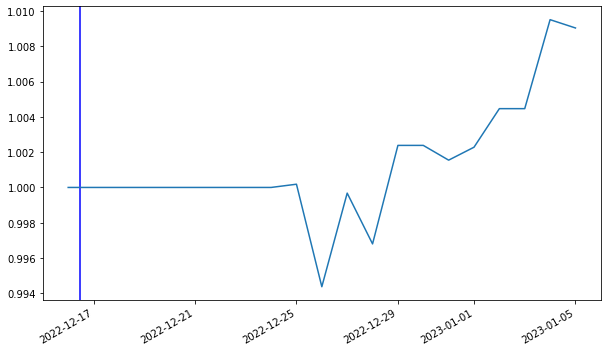

In [64]:
res = analyzers['ETH,XMR']

# If no name has been specified, the name is the class name lowercased
return_analyzer = res.analyzers.getbyname('return')
# print(tret_analyzer.get_analysis())
account_return = pd.Series(return_analyzer.get_analysis(), name='return')
cum_r = (1 + account_return).cumprod()
plt.axvline(x = start_trading_at, color = 'b', label = 'OOS')

cum_r.plot()
plt.show()
